In [26]:
import pyreadr
import numpy as np
import pandas as pd
import json

from pymatreader import read_mat
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression#, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
matplotlib.style.use('ggplot')

In [27]:
def recursionStart(spectra):
    featurePairs = []
    maxima = []
    minima = []
    
    for i in range(1, len(spectra) - 1):
        if spectra[i] > spectra[i-1]:
            if spectra[i] >= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] > spectra[j]:
                        maxima.append([i, spectra[i]])
                        break
                    elif spectra[i] < spectra[j]:
                        break
        if spectra[i] < spectra[i-1]:
            if spectra[i] <= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] < spectra[j]:
                        minima.append([i, spectra[i]])
                        break
                    elif spectra[i] > spectra[j]:
                        break
    maxima.sort(key = lambda element: element[1], reverse = True)
    minima.sort(key = lambda element: element[1])
    
    globalMaxima = maxima.pop(0)
    featurePairs.append([globalMaxima[0], globalMaxima[1] - minima[0][1]])
    
    recursionStep(0, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    recursionStep(len(spectra) - 1, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    
    return featurePairs

def recursionStep(start, end, maxima, minima, featurePairs):
    factor = 1
    if end < start:
        factor = -1
    currentMaxima = []
    for i in range(len(maxima)):
        position = maxima[i][0]
        if start * factor < position * factor and position * factor < end * factor:
            currentMaxima.append(maxima[i])
    if len(currentMaxima) == 0:
        return
    localMaxima = currentMaxima.pop(0)
    recursionStep(start, localMaxima[0], currentMaxima.copy(), minima.copy(), featurePairs)
    currentMinima = []
    for i in range(len(minima)):
        position = minima[i][0]
        if localMaxima[0] * factor < position * factor and position * factor < end:
            currentMinima.append(minima[i])
    localMinima = currentMinima.pop(0)
    featurePairs.append([localMaxima[0], localMaxima[1] - localMinima[1]])
    recursionStep(localMinima[0], localMaxima[0], currentMaxima.copy(), currentMinima.copy(), featurePairs)
    recursionStep(localMinima[0], end, currentMaxima.copy(), currentMinima.copy(), featurePairs)

In [28]:
def getPersistenceTransformation(data_X, listOfK):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X.iloc[i])
        featurePairs.sort(key = lambda element: element[1], reverse = True)
        spectras.append(featurePairs)
        
    spectrasForEachK = []
    
    for k in listOfK:
        transformationForSpectra = []
        for i in range(0, len(spectras)):
            transformation = [0] * len(data_X.iloc[i])
            featurePairs = spectras[i][0:round(k*len(spectras[i]))]
            for x, fx in featurePairs:
                transformation[x] = fx
            transformationForSpectra.append(transformation)
        spectrasForEachK.append(transformationForSpectra)
    return spectrasForEachK

In [29]:
def writeSpectraToFile(path, spectra):
    with open(path, 'a') as fp:
        for s in spectra:
            fp.write(str(s) +"\n")
            
def readSpectraFromFile(path):
    spectra = []
    for line in open(path, 'r'):
        spectra.append(json.loads(line))
    return spectra

In [30]:

def cvAccuracy(tmas, X, resp, classifier):
    
    tmas_names = ['TMA_1:', 'TMA_2:', 'TMA_3:', 'TMA_4:', 'TMA_5:', 'TMA_6:', 'TMA_7:', 'TMA_8:']
    
    tmas_res_test   = []
    tmas_vals_test  = []
    tmas_res_train  = []
    tmas_vals_train = []
    
    for tma in range(1, len(tmas_names)+1):
    
        X_train = X.iloc[tmas[tmas != tma].index, :]

        X_test = X.iloc[tmas[tmas == tma].index, :]

        y_train = resp.iloc[tmas[tmas != tma].index, :]

        y_test = resp.iloc[tmas[tmas == tma].index, :]
        
        if (classifier == 'log'):

            logreg = LogisticRegression(penalty = 'none', solver = 'newton-cg')

            logreg.fit(X_train, y_train.values.ravel())

            y_pred = logreg.predict_proba(X_test)

            y_pred_1 = np.where(y_pred[:, 1] > 0.5, 1, 0)

            accuracy = balanced_accuracy_score(y_test, y_pred_1)
            
            tmas_vals_test.append(accuracy)

            tmp_tmas = [tmas_names[tma-1], accuracy]

            tmas_res_test.append(tmp_tmas)
            
        if (classifier == 'rf'):
            
            rf = RandomForestClassifier(n_estimators= 500, random_state= 1234)
            
            rf.fit(X_train, y_train.values.ravel())
            
            y_pred_rf = rf.predict(X_test)
            
            accuracy = balanced_accuracy_score(y_test, y_pred_rf)
            
            tmas_vals_test.append(accuracy)

            tmp_tmas = [tmas_names[tma-1], accuracy]

            tmas_res_test.append(tmp_tmas)
        
    return tmas_vals_test, tmas_res_test  

def Average(lst):
    return sum(lst) / len(lst)
    

In [31]:
# Loading Data from Matlab
dataMaldi = read_mat('data/L1-8_tic_ad_sq.mat')

X_values = pd.DataFrame(dataMaldi['data_tic'])#Reading the mz-values 
                                #to get pd's as input for the ml
classes = pd.DataFrame(dataMaldi['classes'])#The cancer Typ, result for ml

mz_values = pd.DataFrame(dataMaldi['mzVector'])

TMAs   = pd.Series(dataMaldi['tmas'])

p = X_values.shape[0]

y = pd.DataFrame(np.where(classes == 1, 0, 1))

In [ ]:
listOfk = [0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5]
ListOfXk = getPersistenceTransformation(data_X = X_values, listOfK = listOfk)
X_k1 = ListOfXk[0]
X_k2 = ListOfXk[1]
X_k3 = ListOfXk[2]
X_k4 = ListOfXk[3]
X_k5 = ListOfXk[4]
X_k6 = ListOfXk[5]
X_k7 = ListOfXk[6]

In [ ]:
writeSpectraToFile('intermediate_results/sk1.csv', X_k1)
writeSpectraToFile('intermediate_results/sk2.csv', X_k2)
writeSpectraToFile('intermediate_results/sk3.csv', X_k3)
writeSpectraToFile('intermediate_results/sk4.csv', X_k4)
writeSpectraToFile('intermediate_results/sk5.csv', X_k5)
writeSpectraToFile('intermediate_results/sk6.csv', X_k6)
writeSpectraToFile('intermediate_results/sk7.csv', X_k7)

In [13]:
#s1 = X_values.loc[[22]]
#s2 = pd.DataFrame(X_k1).loc[[22]]
#s3 = pd.DataFrame(X_k2).loc[[22]]
#s4 = pd.DataFrame(X_k5).loc[[22]]

In [19]:
#print(np.count_nonzero(s2), np.count_nonzero(s3), np.count_nonzero(s4))

5 24 118


In [21]:
#rf_raw_1, rf_raw_2 = cvAccuracy(tmas =TMAs, resp=y, X = X_values, classifier='rf')
#rf_k1_1, rf_k1_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k1), classifier = 'rf')
#rf_k2_1, rf_k2_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k2), classifier = 'rf')
#rf_k3_1, rf_k3_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k3), classifier = 'rf')
#rf_k4_1, rf_k4_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k4), classifier = 'rf')
#rf_k5_1, rf_k5_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k5), classifier = 'rf')
#rf_k6_1, rf_k6_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k6), classifier = 'rf')

In [ ]:
#print(Average(rf_raw_1), Average(rf_k1_1), Average(rf_k2_1), Average(rf_k3_1), Average(rf_k4_1), Average(rf_k5_1), Average(rf_k6_1))

In [13]:
q1, q2 = cvAccuracy(tmas =TMAs, resp=y, X = X_values, classifier='log')
res_k1_1, res_k1_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k1), classifier = 'log')
res_k2_1, res_k2_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k2), classifier = 'log')
res_k3_1, res_k3_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k3), classifier = 'log')
res_k4_1, res_k4_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k4), classifier = 'log')
res_k5_1, res_k5_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k5), classifier = 'log')
res_k6_1, res_k6_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k6), classifier = 'log')
res_k7_1, res_k7_2 = cvAccuracy(tmas =TMAs, resp=y, X = pd.DataFrame(X_k7), classifier = 'log')

In [17]:
print(Average(q1[::2]), Average(res_k1_1[::2]), Average(res_k2_1[::2]),
      Average(res_k3_1[::2]), Average(res_k4_1[::2]), Average(res_k5_1[::2]), Average(res_k6_1[::2]), Average(res_k7_1[::2]))

0.8543491108122071 0.6651460684526553 0.7429994694276305 0.8569487575651537 0.8622455771283603 0.8572790691659951 0.8836458115027419 0.8814363847386475


<AxesSubplot:>

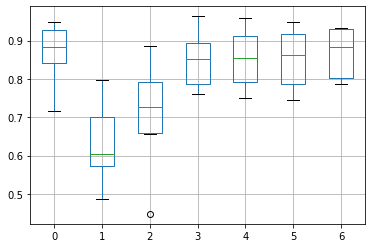

In [20]:
results = pd.concat([pd.Series(q1[::2]), pd.Series(res_k1_1[::2]), pd.Series(res_k2_1[::2]), pd.Series(res_k3_1[::2]), 
                     pd.Series(res_k4_1[::2]), pd.Series(res_k5_1[::2]),
                     pd.Series(res_k6_1[::2])], axis=1)

results = pd.DataFrame(results)

results.boxplot()
#sns.boxplot(results.iloc[:, 0:1])